# Depth Space --> Density Space

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import argopy
import glidertools as gt

In [2]:
import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df

In [81]:
reload(ff)
reload(ef)
reload(pf)
reload(df)

<module 'density_funcs' from '/home.ufs/amf2288/argo-intern/density_funcs.py'>

In [4]:
s_z   = xr.open_dataset('202206_boxes/lon:(25,45)_lat:(-60,-50)_ds_z.nc')
s_rho = xr.open_dataset('202206_boxes/lon:(25,45)_lat:(-60,-50)_ds_rho.nc')

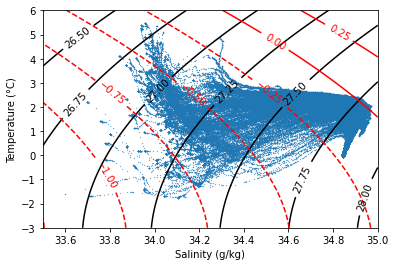

In [5]:
ds_li=[s_z]
Taxis=[-3,6,50]
Saxis=[33.5,35,50]

pf.plot_TS(ds_li, Taxis, Saxis)

In [6]:
print(s_z.SIG0.values.max(), s_z.SIG0.values.min())

27.86234453739975 26.664209814720152


In [7]:
rho_grid = np.linspace(26.5,28,1001)

In [8]:
s_rho

<xarray.Dataset>
Dimensions:            (rho_grid: 1001, N_PROF_NEW: 335)
Coordinates:
  * rho_grid           (rho_grid) float64 26.6 26.6 26.6 26.6 ... 28.0 28.0 28.0
  * N_PROF_NEW         (N_PROF_NEW) int64 0 1 2 3 4 5 ... 330 331 332 333 334
Data variables:
    PRES_INTERPOLATED  (rho_grid, N_PROF_NEW) float64 ...
    CT                 (rho_grid, N_PROF_NEW) float64 ...
    SA                 (rho_grid, N_PROF_NEW) float64 ...
    SIG0               (rho_grid, N_PROF_NEW) float64 ...
    SPICE              (rho_grid, N_PROF_NEW) float64 ...

In [9]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 10

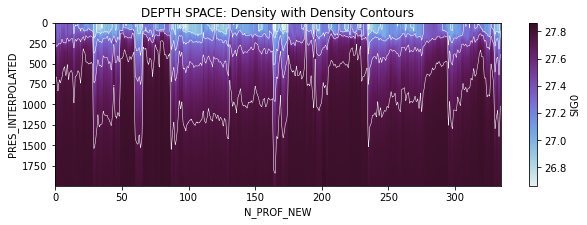

In [10]:
#why is the colorbar y axis switched? that didn't happen with the temperature plot below

plt.figure(figsize=(10,3))
s_z.SIG0.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',cmap=cmo.dense, rasterized=True)
s_z.SIG0.plot.contour(y='PRES_INTERPOLATED',x='N_PROF_NEW',levels=[26.5,26.75,27,27.25,27.5,27.75,28, 28.25, 28.5], 
                     colors='w', linewidths=0.5)
plt.gca().invert_yaxis()
plt.title('DEPTH SPACE: Density with Density Contours');

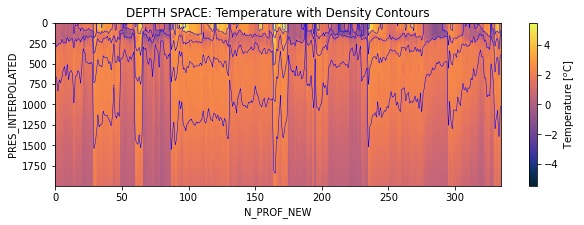

In [11]:
plt.figure(figsize=(10,3))
s_z.CT.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',
           cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
s_z.SIG0.plot.contour(y='PRES_INTERPOLATED',x='N_PROF_NEW',levels=[26.5,26.75,27,27.25,27.5,27.75,28], 
                     colors='b', linewidths=0.5)
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED')
plt.xlabel('N_PROF_NEW')
plt.title('DEPTH SPACE: Temperature with Density Contours');

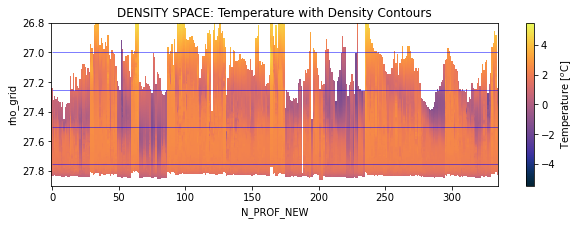

In [12]:
plt.figure(figsize=(10,3))

s_rho.CT.plot(y='rho_grid', x='N_PROF_NEW',
               cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
plt.hlines([26.5,26.75,27,27.25,27.5,27.75,28],0, 350, linewidths=0.5, colors='b')
plt.gca().invert_yaxis()
plt.ylim(27.9,26.8)
plt.title('DENSITY SPACE: Temperature with Density Contours');

In [13]:
from scipy import interpolate

In [14]:
def func_var_int_pmean(ds, Pmean_smooth, Pmax, variable='SPICE', dim1='N_PROF_NEW',): 
    Pmean_grid = np.linspace(0,Pmax,Pmax//2)
    
    ds_nonan = ds[variable].where(~np.isnan(ds[variable]) & ~np.isnan(Pmean_smooth), drop=True)
    
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds[variable]) & ~np.isnan(Pmean_smooth), drop=True)

    
    if len(ds_nonan) > 2:
       
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        
        ds_on_Pmean = f(Pmean_grid)
            
        
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', dim1],
                        coords = {'Pmean': Pmean_grid, dim1: [ds[dim1].values]}).rename(variable)

In [20]:
ds=s_rho
N_PROF_NEW_ind=0
Pmax=1100
roll = 150

Pmean_smooth = ds.PRES_INTERPOLATED.mean('N_PROF_NEW').rolling(rho_grid= roll, center=True).mean()
Spice_on_Pmean = func_var_int_pmean(ds.isel(N_PROF_NEW=N_PROF_NEW_ind), Pmean_smooth, Pmax)

for N_PROF_NEW_ind in range(1, len(ds.N_PROF_NEW)):
    Spice_on_Pmean = xr.concat([Spice_on_Pmean, func_var_int_pmean(ds.isel(N_PROF_NEW=N_PROF_NEW_ind), Pmean_smooth, Pmax)]
                              , dim='N_PROF_NEW')

Text(0, 0.5, 'Mean Isopycnal Depth [m]')

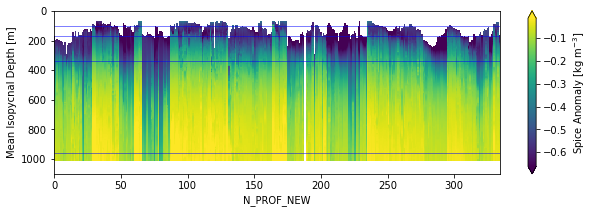

In [22]:
plt.figure(figsize=(10,3))
Spice_on_Pmean.plot(cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'}, robust=True)
plt.hlines(Pmean_smooth.sel(rho_grid=[26.5,26.75,27,27.25,27.5,27.75,28], method='nearest').values,0, 1.7e6, 
          linewidths=0.5, colors='b')
plt.gca().invert_yaxis()
plt.ylabel('Mean Isopycnal Depth [m]')

In [79]:
n=0
dim='Pmean'
mean_prof = Spice_on_Pmean.isel({dim:n}).mean(skipna=True)
anom_prof = Spice_on_Pmean.isel({dim:n}) - mean_prof

for n in range(1,len(Spice_on_Pmean[dim])):
    mean_prof = Spice_on_Pmean.isel({dim:n}).mean(skipna=True)
    anom_prof_next = Spice_on_Pmean.isel({dim:n}) - mean_prof

    anom_prof = xr.concat([anom_prof, anom_prof_next], dim=dim)

Text(0, 0.5, 'Mean Isopycnal Depth [m]')

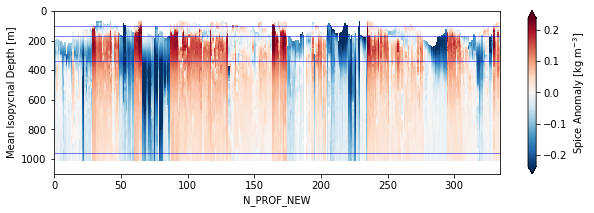

In [80]:
plt.figure(figsize=(10,3))
anom_prof.plot(cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'}, robust=True)
plt.hlines(Pmean_smooth.sel(rho_grid=[26.5,26.75,27,27.25,27.5,27.75,28], method='nearest').values,0, 1.7e6, 
          linewidths=0.5, colors='b')
plt.gca().invert_yaxis()
plt.ylabel('Mean Isopycnal Depth [m]')

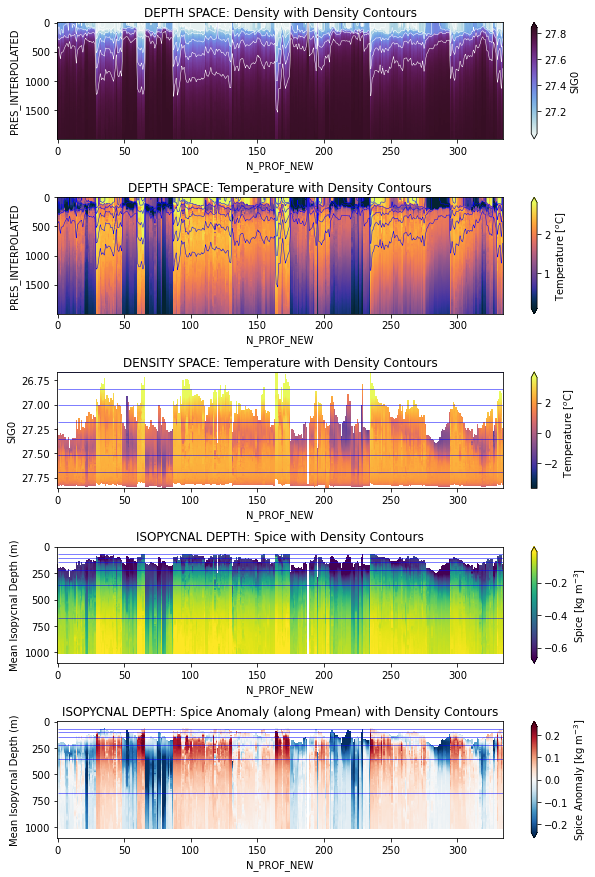

In [82]:
pf.plot_depth_profs(s_z, s_rho, Pmax=1100, roll=150)

## Load Based on Float Profile

Wanted to take a look at a similar analysis as above, but for one float, with a "distance" axis instead of an "N_PROF" axis (more similar to a glider).

In [32]:
float_IDs = np.unique(s_z.PLATFORM_NUMBER)
float_IDs

array([1901700, 1901831, 1901832, 1902269, 1902281, 1902292, 1902294,
       1902295, 1902296, 1902297, 1902298, 1902330, 2902164, 3901113,
       3901222, 3901223, 3901224, 3901833, 3901879, 3901888, 3901962,
       5901719, 5901723, 5901725, 5901726, 5905135, 5905996, 7900110,
       7900198, 7900202, 7900203, 7900305], dtype=int32)

In [34]:
fl0_z   = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
fl0_rho = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

fl2_z   = xr.open_dataset('202206_floats/float_ID:(1901832)_ds_z.nc')
fl2_rho = xr.open_dataset('202206_floats/float_ID:(1901832)_ds_z.nc')

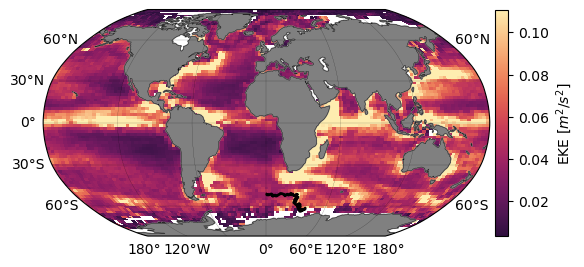

In [35]:
pf.plot_dist(fl0_z)

In [37]:
fl0_dist = df.interp_distance(fl0_z)

In [38]:
rho_grid_0 = np.linspace(26.8,27.8,1001)

In [40]:
fl0_rho = df.interpolate2density_dist(fl0_dist, rho_grid_0)

50
100


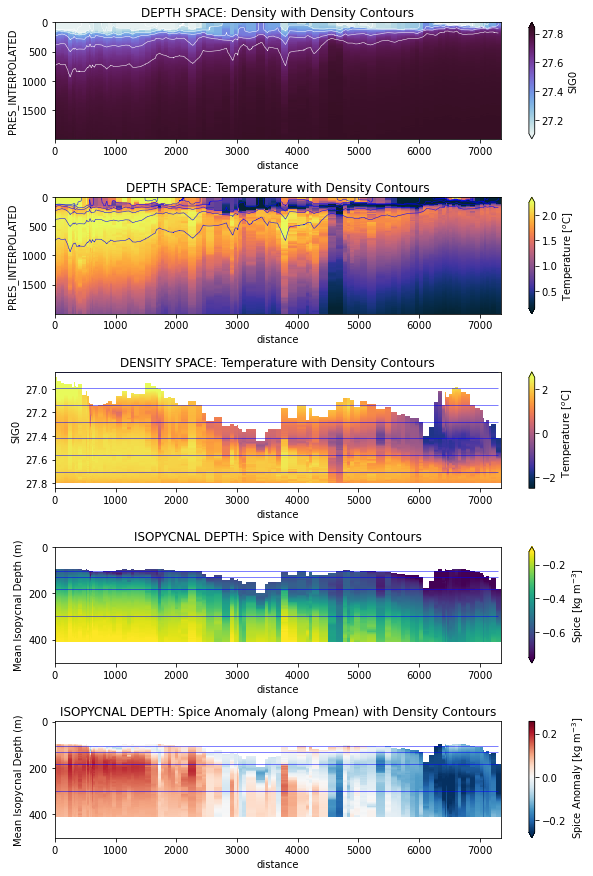

In [83]:
pf.plot_depth_profs(fl0_dist, fl0_rho, Pmax=500, roll=350, dim1='distance')

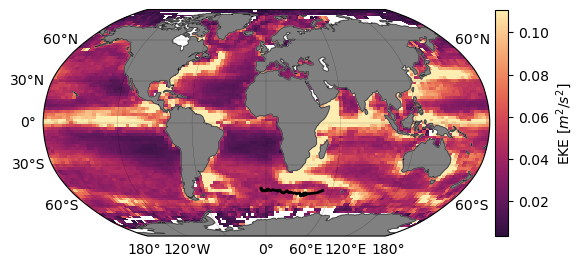

In [42]:
pf.plot_dist(fl2_z)

In [44]:
fl2_dist = df.interp_distance(fl2_z)

In [45]:
rho_grid_2 = np.linspace(26.75,27.75,1001)

In [46]:
fl2_rho = df.interpolate2density_dist(fl2_dist, rho_grid_2)

50


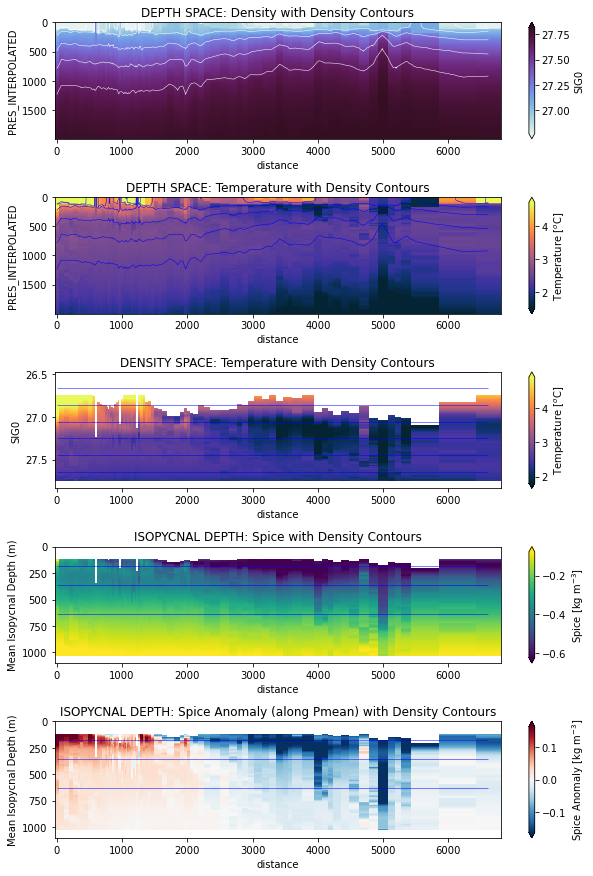

In [84]:
pf.plot_depth_profs(fl2_dist, fl2_rho, Pmax=1100, roll=250, dim1='distance')